# Localización de eventos: Ejemplo de caída libre de pelota de ping-pong con rebote

<ul id="top">
<li><a href="#1-Problema-caida-libre-de-pelota-ping-pong">1-Problema caida libre de pelota ping-pong</a></li>
<li><a href="#2-Resolución-del-problema-de-valor-inicial">2-Resolución del problema de valor inicial </a></li>
<li><a href="#3-Impacto-de-la-pelota-contra-el-suelo:-cálculos-preliminares">3-Impacto de la pelota contra el suelo: cálculos preliminares</a></li>
<li><a href="#4-Determinación-del-instante-del-impacto-con-intepolación-lineal">4-Determinación del instante del impacto con intepolación lineal </a></li>
<li><a href="#5-Determinación-del-instante-de-impacto-con-intepolación-cúbica-de-Hermite">5-Determinación del instante de impacto con intepolación cúbica de Hermite</a></li>
<li><a href="#6-Simulación-de-los-botes-de-la-pelota">6-Simulación de los botes de la pelota</a></li>
<li><a href="#Valoración">Valoración</a></li>
</ul>  

In [1]:
using Plots

In [2]:
using DelimitedFiles

## 1-Problema caida libre de pelota ping-pong

En este ejercicio volveremos a considerar el ejemplo de una pelota de ping-pong que se deja caer bajo la influencia de la fuerza de la gravedad y la resistencia del aire.


La evolución de la altura (a la que está el centro de la pelota) y la velocidad de la pelota a lo largo del tiempo se puede  modelar por medio del siguiente sistema de ecuaciones diferenciales, donde 
- la altura $x$ y la velocidad $v$ son las variables de estado  (y por tanto $u=(x,v)$ es el vector de estados del sistema),
- los parámetros constantes del problema son: $g$, la aceleración de la gravedad; $M$, la masa de la pelota;  $R$, el radio de la pelota; $\mu$, la viscosidad dinámica del aire; $\rho = 1.205$ la densidad del aire. En concreto, consideraremos los siguientes valores:
$g=9.8\, m/\mathrm{seg}^2$, $M=0.0028\, \mathrm{kg}$,  $R=0.02\, m$, $\mu = 1.789\times 10^{-5}\,  \mathrm{kg}/(m \, \mathrm{seg})$, y $\rho = 1.205\,  \mathrm{kg}/m^3$.
- el sistema de EDOs es
\begin{align*}
  \frac{d x}{dt}  &= v, \\
   \frac{d v}{dt} &= -g -  \frac{\rho\, \pi\, R^2\, C_D(Re)}{2\, M}\, \left|v\right|\, v,
\end{align*}
donde 
\begin{equation*}
        Re = \frac{2\, \rho_a\, R}{\mu_a} |v|, \quad
        C_D(Re)  = \left\{
        \begin{array}{cl}
        \displaystyle
       \frac{24}{Re} + \frac{2}{5} +\frac{6}{1+\sqrt{Re}} & \mbox{ si  } Re>0,\\
              \displaystyle
       0  \phantom{ \frac{2}{5} +\frac{6}{1+\sqrt{Re}} }  & \mbox{ si } Re=0.
        \end{array}
        \right. 
\end{equation*}
Aquí, $C_D(Re)$ es el _coeficiente de arrastre_ de un fluido cualquiera sobre  una esfera de superficie suave, que es función del _número de Reynols_ $Re$, diréctamente proporcional a la magnitud de la velocidad $|v|$ de la esfera.
Las unidades utilizadas son metros para la longitud, segundos para el tiempo, y kilogramos para la masa.

###  El sistema de EDOs

Sabemos que dicho sistema de EDOs se puede escribir de forma compacta como

<a id='Edo-Comp'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p),\hspace{6em} \tag{1}
\end{equation*}
donde $u=(x,v)$, y $p=(g,M,R,\mu,\rho)$.

### 1.1-Ejercicio
Implementar la función $f$ de [(1)](#Edo-Comp) 

In [3]:
function fpelota(t,u,p)
  x = u[1]
  v = u[2]
    
  g=p[1]
  M=p[2]
  R=p[3]
  mu=p[4]
  rho=p[5]
  
  Re = (2*rho*R)/mu * abs(v)
  if Re == 0 
    Cd = 0
  else
    Cd = 24/Re + 2/5 + 6/( 1 + sqrt(Re) )
  end
    
  dx = v 
  dv = -g - (rho*pi*R^2*Cd)/(2*M) * abs(v) * v
  
  return [dx, dv]
end

fpelota (generic function with 1 method)

### 1.2-Ejercicio (Comprobación) 
Para descartar posibles fallos en su implementación, evaluar dicha función para $t=0$, $u = (3,4)$, y los valores de los parámetros constantes dados arriba. 

In [4]:
t = 0
u = [3,4]
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

res = fpelota(t,u,p)

print(res[1])
print("\n")
print(res[2])

4.0
-11.787870675290915

>**Resultado esperado:** El vector de dos componentes $(4,-11.787870675290915)$.
>

<a href="#top">Back to the top</a>

## 2-Resolución del problema de valor inicial 
A partir de ahora, consideraremos el caso en que inicialmente se deja la pelota a 2 metros de altura con velocidad nula, es decir
$$
x(0)=2, \quad v(0)=0.
$$

### 2.1-Ejercicio (Aplicación de RK4)

Aplicar el método RK4 con longitud de paso $h=1/240$ para obtener aproximaciones $(x_j,v_j)$ de la altura y velocidad $(x(t_j),v(t_j))$ de la pelota en los tiempos

<a id='tiempos2'></a>
\begin{equation*}
  t_0=0, \  t_1=h, \  t_2 = 2h, \ldots, t_{2398}=2398h, \  
t_{2399}=2399h, \  t_{2400}=2400h=10.
\end{equation*}

In [5]:
"""
Metodo de Runge-Kutta de orden 4
""" 
function  RK4(u0, t0, T, n, f, p, m=1)
    h = (T-t0)/(n*m);   # Calculo de la longitud de paso
    # Se deduce la dimension del sistema de EDOs a partir del numero 
    # de componentes del vector de estado inicial
      d = length(u0)  
    # Inicializacion a cero de la matriz de salida de resultados
      W = zeros(n+1,d+1)
      W[1,:] = [t0; u0]  # Se rellena la primera fila de la matriz de resultados 
      tj = t0
      uj = u0
    # Calculo sucesivo de los tiempos tj y las aproximaciones uj de u(tj)
    for j in 1:n
        for i in 1:m
        uj = RK4step0(tj,uj,h,f,p)
        tj = tj + h
        end
        W[j+1,:] = [tj; uj] # Se introduce el resultado del paso j-ésimo 
                            # en la fila (j+1)-ésima de la matriz de resultados
    end
    return W
  end

function RK4step0(t0,u0,h,f,p)
        k1 = f(t0, u0, p)
        uuj = u0 + h/2*k1 
        k2 = f(t0+h/2, uuj, p)
        uuj = u0 + h/2*k2
        k3 = f(t0+h/2, uuj, p)
        uuj = u0 + h*k3
        k4 = f(t0+h, uuj, p)
        u1 = u0 + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        return u1
end
    

RK4step0 (generic function with 1 method)

In [6]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

res = RK4([2,0], 0, 10, 2400, fpelota, p,1)

tt = res[:,1]
xx = res[:,2]
vv = res[:,3];

In [7]:
print( length(tt) )
print("\n")
print( tt[length(tt)] )

2401
9.999999999999753

### 2.2-Ejercicio (Comprobación)
Mostrar los resultados de $(t,x,v)$ para los primeros tiempos $t_0,t_1,t_2,t_3$.

In [8]:
res[1:4,:]

4×3 Array{Float64,2}:
 0.0         2.0       0.0      
 0.00416667  1.99991  -0.0408325
 0.00833333  1.99966  -0.0816616
 0.0125      1.99923  -0.122485 

>**Resulado esperado:** La tabla de los resultados de $(t,x,v)$ para los tiempos $t_0,t_1,t_2,t_3$ que se debería >obtener es la siguiente:
>
>         0.0         2.0       0.0      
>         0.00416667  1.99991  -0.0408325
>         0.00833333  1.99966  -0.0816616
>         0.0125      1.99923  -0.122485 

### 2.3-Ejercicio
Representar en una gráfica la evolución de la altura $x$.

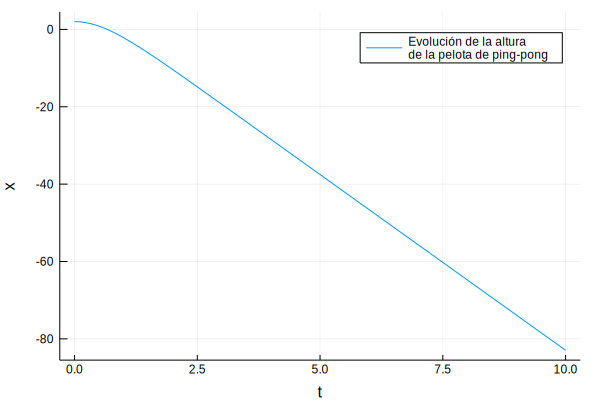

In [9]:
plot(tt,xx, xlabel="t", ylabel="x",label="Evolución de la altura\n de la pelota de ping-pong")

<a href="#top">Back to the top</a>

## 3-Impacto de la pelota contra el suelo: cálculos preliminares
En dicha gráfica, se ve la evolución de la altura de la pelota de ping-pong en el caso en que no hubiera suelo. En cambio, si el suelo está a 0 metros de altura, entonces, dicha evolución de la altura de la pelota sólo es válida hasta el instante en que la pelota toca el suelo. 

### 3.1-Ejercicio

**Determinar el intervalo $[t_j,t_{j}+h]$ en el que la pelota choca contra el suelo.**

Recordar que $x$ es la altura a la que está el centro de la pelota, de modo que para determinar dicho intervalo, hay que tener en cuenta el radio de la misma.

In [10]:
R = 0.02#radio de la pelota

selIx = 0
for ix in 1:size(res,1)-1
    # signo(g (t j , u j )) != signo(g (t j+1 , u j+1 ))
    if sign(res[ix,2]-R) != sign(res[ix+1,2]-R)
        selIx = ix
        break
    end
end

print(selIx)
print("\n")
print(res[selIx,2]-R)
print("\n")
print(res[selIx+1,2]-R)

159
0.022771711088606903
-0.00026405965131155035

In [11]:
j = selIx
tj = res[selIx,1]
tj1 = res[selIx+1,1]
println("j= $j")
println("tj = $tj")
println("tj1 = $tj1")

j= 159
tj = 0.6583333333333322
tj1 = 0.6624999999999989


### 3.2-Ejercicio: comprobación

**Cuales son los valores para dicho $j$, de la altura $x_j$ y la velocidad $v_j$ de la pelota?**

In [12]:
xj = res[selIx,2]
vj = res[selIx,3]
println("xj = $xj")
println("vj = $vj")

xj = 0.042771711088606904
vj = -5.515911580368599


>**Valores esperados:**  $x_j = 0.042771711088606904$, $v_j = -5.515911580368599$.
>

### 3.3-Ejercicio : función que caracteriza el impacto

Definimos una función $g(t,u,p)$ con los mismos argumentos de entrada que la función $f(t,u,p)$, y que devuelva un número real, tal que: (1) cuando devuelve un número positivo, indica que la pelota está por encima del suelo; (2) cuando vale 0, indica que la pelota está tocando el suelo; cuando da como resultado un número negativo, indica que la posición de la pelota no es factible (porque implicaría que ha atravesado el suelo).

In [13]:
function gSuelo(t,u,p)
    u[1]-p[3]
end

gSuelo (generic function with 1 method)

In [14]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

println(gSuelo(res[j,1],res[j,2],p))
println(gSuelo(res[j+1,1],res[j+1,2],p))

0.022771711088606903
-0.00026405965131155035


<a href="#top">Back to the top</a>

## 4-Determinar del instante del impacto con intepolación lineal 

### 4.1-Ejercicio:  cálculo del valor de $t$ en el que ocurre el impacto
Calcular de forma aproximada el instante $t^* \in [t_j,t_{j+1}]$ en el que la pelota impacta contra el suelo. Utilizar la técnica descrita en la última transparencia de la segunda parte del Tema 3.

In [15]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

aux1 = gSuelo(res[j,1],res[j,2],p)*(tj1-tj)
aux2 = gSuelo(res[j+1,1],res[j+1,2],p) - gSuelo(res[j,1],res[j,2],p)
tImp = tj - aux1/aux2

println("Impacto en t= $tImp")

Impacto en t= 0.6624522373894245


### 4.2-Ejercicio: Precisión de la localización temporal del impacto
Para estimar la precisión del tiempo $t^*$ de impacto de la obtenido, conviene tener en cuenta que si $t^*$ fuera exactamente el instante en que la pelota toca por primera vez el suelo, y conociéramos exactamente $u(t^*)$, entonces $g(t^*,u^*,p)$ sería exactamente 0.
Para estimar cómo de cerca está el tiempo $t^*$ calculado del tiempo exacto de impacto contra el suelo, se aplicará el procedimiento propuesto en las transparencias de la segunda parte del Tema 3 para medir la precisión de la localización temporal de eventos. En concreto, se requiere **aplicar un paso  del método RK4 para calcular  (de forma aproximada)  $u^* \approx u(t^*)$ a partir de $u_j \approx u(t_j)$, y comprobar hasta que punto $g(t^*,u^*,p)$ es cercano a cero.**

In [16]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

uj = res[j,2:3]

uImp = RK4step0(tj,uj,tImp-tj,fpelota,p)[1]

println( abs(gSuelo(tImp,uImp,p)) )

5.973021883071139e-7


>**Resultado esperado:** $|g(t^*,u^*,p)| =5.973\ldots\times 10^{-7}$.
>
>Se confirma que la precisión de la aproximación obtenida para el instante del impacto es razonable.

<a href="#top">Back to the top</a>

## 5-Determinar del instante de impacto con intepolación cúbica de Hermite
Queremos calcular  de forma aproximada el instante $t^* \in [t_j,t_{j+1}]$ en el que la pelota impacta contra el suelo, utilizando para ello la interpolación cúbica de Hermite.

### 5.1-Ejercicio: Implementación de una función para el cálculo del polinomio interpolador de Hermite

**Se requiere definir una función (que llamaremos _HermiteInterpCoef_)** que, dados los nodos $t_0$ y $t_1$, los valores $q_0,q_1$ de la función a interpolar en $t=t_0$ y $t=t_1$ respectivamente, y los valores $p_0,p_1$ de la derivada de la función en dichos valores de $t$, permita calcular los coeficientes del polinomio de interpolación de Hermite cúbico $$a\, (t-t_0)^3+ b\, (t-t_0)^2 + c\, (t-t_0) + d.$$ 
**Los argumentos de entrada de  _HermiteInterpCoef_ serán $t_0,t_1,q_0,q_1,p_0,p_1$, y como argumento de salida devolverá un array de cuatro componentes $a,b,c,d$.**

In [17]:
function HermiteInterpCoef(t0,t1,q0,q1,p0,p1)
    
    d = q0
    
    c = p0
    
    b = ( -(2*p0+p1)*(t1-t0) + 3*(q1-q0) ) / ((t1-t0)^2)
    
    a = ( (p0+p1)*(t1-t0) - 2*(q1-q0) ) / ((t1-t0)^3)
    
    return (a,b,c,d)
end    

HermiteInterpCoef (generic function with 1 method)

### 5.2-Ejercicio: Comprobación de la función HermiteInterpCoef

- **Elegir valores reales concretos cualesquiera (por ejemplo, elegidos aleatoriamente con rand()) para $a,b,c,d,t_0,t_1$,**

In [18]:
r = rand(6)
a,b,c,d = HermiteInterpCoef( r[1],r[2],r[3],r[4],r[5],r[6] )

(5.9834026684787505, -3.150975502075311, 0.17974146886857878, 0.410823090932964)

- **Definir el polinomio $q(t)=a\, (t-t_0)^3+ b\, (t-t_0)^2 + c\, (t-t_0) + d.$ y su derivada 
$p(t)=3\, a\, (t-t_0)^2+ 2\, b\, (t-t_0)^2 + c$, calcular $q_0=q(t_0)$, $q_1=q(t_1)$,  $p_0=p(t_0)$, $p_1=p(t_1)$, y llamar a la función HermiteInterpCoef con los valores concretos de $t_0,t_1,q_0,q_1,p_0,p_1$ obtenidos. Debe de devolver exactamente (salvo pequeños errores de redondeo) los valores $a,b,c,d$ de partida.**

In [19]:
function qq(t0,t,a,b,c,d) 
    return a*( (t-t0)^3 ) + b*( (t-t0)^2 ) + c*(t-t0) + d
end

function pp(t0,t,a,b,c)
    return 3*a*( (t-t0)^2 ) + 2*b* ( (t-t0) ) + c 
end

pp (generic function with 1 method)

In [20]:
q0 = qq(r[1],r[1],a,b,c,d)
q1 = qq(r[1],r[2],a,b,c,d)

p0 = pp(r[1],r[1],a,b,c)
p1 = pp(r[1],r[2],a,b,c)

0.5293786186474743

In [21]:
a2,b2,c2,d2 = HermiteInterpCoef( r[1],r[2],q0,q1,p0,p1 )#,q0,q1,p0,p1

println([a,a2])
println([b,b2])
println([c,c2])
println([d,d2])

[5.9834, 5.9834]
[-3.15098, -3.15098]
[0.179741, 0.179741]
[0.410823, 0.410823]


In [22]:
println([q0,r[3]])
println([q1,r[4]])
println([p0,r[5]])
println([p1,r[6]])

[0.410823, 0.410823]
[0.361395, 0.361395]
[0.179741, 0.179741]
[0.529379, 0.529379]


>**Comentar el resultado**

> Podemos ver que si llamamos la función HermiteInterpCoef con los valores concretos de $t_0,t_1,q_0,q_1,p_0,p_1$ obtenidos, devuelve exactamente (salvo pequeños errores de redondeo) los valores $a,b,c,d$ de partida.
>
> Sabemos que d = q0 y que c = p0, por lo cual este resultado es trivial, porque dado que d=q0 y c=p0 siempre conseguiremos de reproducir d y c a partir de p0 y q0.
> 
> Tambien podemos ver que los valores obtenidos $t_0,t_1,q_0,q_1,p_0,p_1$ son iguales que los valores elegidos aleatoriamente con rand(), por lo cual es trivial que obtenemos los mismos valores $a,b,c,d$ de partida.

### 5.3-Ejercicio:  Definición de la ecuación a resolver

En el siguiente apartado determinaremos el instante $t$ en que la pelota impacta contra el suelo resolviento la ecuación 
$$ \tilde G(t) = 0, \hspace{6em} (2)$$
donde $\tilde G(t) \approx g(t,u(t),p)$.

En este punto hay que definir la función $\tilde G(t):= g(t,\tilde u(t),p)$, donde $g(t,u,p)$ se ha definido anteriormente, y $\tilde u(t)$ está definido a partir de las aproximaciones disponibles de 
\begin{equation*}
u(t_j), \quad u(t_{j+1}), \quad u'(t_j)=f(t_j,u(t_j),p), 
\quad u'(t_{jç1})=f(t_{j+1},u(t_{j+1}),p).
\end{equation*}
En el siguiente apartado determinaremos el instante $t$ en que la pelota impacta contra el suelo resolviento la ecuación (2).

**Se requiere por tanto definir la función $\tilde G(t)$ asociada al impacto de la pelota contra el suelo.**
La función $\tilde G(t)$ la implementaremos como una función de Julia (que llamaremos Gsuelo) que tome como argumentos de entrada $t$,  y que devuelva el valor de $\tilde G(t)$. (Los valores de $t_j$, $t_{j+1}$, $u_j$, $u_{j+1}$, y $R$ estarán fijados como variables globales).

 **Nota:** En el caso concreto que nos ocupa, tenemos que $g(t,u,p)$ (donde $u=(x,v)$) no depende de $v$. Por tanto, para definir $\tilde G(t)$ en nuestro ejemplo de la pelota, basta con obtener el polinomio de Hermite cúbico $\tilde x(t)$ que aproxima $x(t)$. Para ello, usaremos la función HermiteInterpCoef definida en el apartado anterior. 

In [23]:
v0 = res[j,3]
v1 = res[j+1,3]
q0 = res[j,2]
q1 = res[j+1,2]

pp0 = fpelota(tj,[q0,v0],p)
pp1 = fpelota(tj1,[q1,v1],p)
p0 = pp0[1]
p1 = pp1[1]
println(p0)
println(p1)

-5.515911580368599
-5.5412353723356755


In [24]:
a,b,c,d = HermiteInterpCoef( tj,tj1,q0,q1,p0,p1 )

(1.3249415013767558, -3.0471359204329076, -5.515911580368599, 0.042771711088606904)

In [25]:
function Gsuelo(t)
    xt = qq(tj,t,a,b,c,d)
    xt-R
end

Gsuelo (generic function with 1 method)

### 5.4-Ejercicio: Comprobación de la función $\tilde G(t)$

Como comprobación de que se ha implementado correctamente la función $\tilde G(t)$, se requiere evaluar dicha función  en $t=\frac{t_j+t_{j+1}}{2}$. 

In [26]:
Gt = Gsuelo((tj+tj1)/2)
println(Gt)

0.01126701519363053


>**Resultado**

>Valor esperado: 0.01126701519363053

### 5.5-Ejercicio:  Cálculo del tiempo de impacto

**Calcularemos el valor  $t^* \in [t_j,t_{j+1}]$ tal que 
$\tilde G(t^*)=0$**, como aproximación del instante
en el que la pelota impacta contra el suelo.

Calcularemos dicha solución de la ecuación $\tilde G(t)=0$ por medio de un método iterativo conocido como _método de la secante_. En conreto, se irán calculando los valores $T_0, T_1, T_2,\ldots$, que irán convergiendo hacia la solución buscada, como sigue:
- Se parte de $T_0=t_j$, $T_1 = t_{j+1}$, $G_0 =\tilde G(T_0)$,  $G_1 =\tilde G(T_1)$, 
- y para  $j=1,2,3,\ldots$, se calculan sucesivamente los valores
$$  T_{j+1} = T_j - \frac{G_j}{G_j-G_{j-1}}(T_j-T_{j-1}), \quad G_{j+1} = \tilde G(T_{j+1}),$$
En la práctica, no se ejecuta un número finito de iteraciones. Un criterio de parada que funciona muy bien, y que aplicaremos aquí, consiste parar en la iteración $j$-ésima (sin llegar a calcular $T_{j+1}$), si 
$|G_j| \geq  |G_j - G_{j-1}|$. En ese caso, tomaremos $t^* = T_j$.

In [27]:
T = zeros(1000,1)
T[1] = tj
T[2] = tj1

G = zeros(1000,1)
G[1] = Gsuelo(T[1])
G[2] = Gsuelo(T[2])

ix = 2

2

In [28]:
while true
    
    if abs(G[ix]) >= abs(G[ix]-G[ix-1])
        break
    end
    
    T[ix+1] = T[ix] - ( G[ix]/(G[ix] - G[ix-1]) ) * (T[ix]-T[ix-1]) 
    G[ix+1] = Gsuelo(T[ix+1])
    ix = ix+ 1

end

tImpacto = T[ix]

0.6624523451872922

>**Resultado**

>**Valor esperado:**: $t^* = 0.662452345187\ldots$.

### 5.6-Ejercicio:  Precisión de la localización temporal del impacto
Se trata ahora de estimar la precisión del tiempo $t^*$ de impacto obtenido, tal como se ha hecho en el apartado anterio. En concreto, se requiere **aplicar un paso  del método RK4 para calcular  (de forma aproximada)  $u^* \approx u(t^*)$ a partir de $u_j \approx u(t_j)$, y comprobar hasta que punto $g(t^*,u^*,p)$ es cercano a cero.**

In [29]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

uj = res[selIx,2:3]

uImpacto = RK4step0(tj,uj,tImpacto-tj,fpelota,p)[1]

abs( gSuelo(tImpacto,uImpacto,p) )

3.3514857555871913e-15

>**Resultado esperado:** $|g(t^*,u^*,p)| =3.35\ldots \times 10^{-15}$.

>**Comentar el resultado, comparándolo con lo obtenido con la interpolación lineal.**
>
> El resultado obtenido con la interpolacion lineal es 5.973021883071139e-7.
>
> El resultado obtenido con la interpolacion cubica de Hermite es 3.3514857555871913e-15.
>
> Sabemos que cuanto mas pequeño esta $|g(t^*,u^*,p)|$ (cuanto mas cercano a 0 sea), mayor
precision.
>
> Por lo cual podemos concluir que el resultado obtenido con la interpolacion cubica de Hermite es ~8 ordenes de magnituda mas preciso que la interpolacion lineal.

<a href="#top">Back to the top</a>

## 6-Simulación de los botes de la pelota

El objetivo de este apartado es calcular los valores de la altura $x$ de la pelota en los tiempos 
\begin{equation*}
  t_0=0, \  t_1=h, \  t_2 = 2h, \ldots, t_{2398}=2398h, \  
t_{2399}=2399h, \  t_{2400}=2400h=10.
\end{equation*}
donde $h=1/240$, suponiendo que cada vez que la pelota llega a tocar el suelo según va cayendo la pelota, en dicho instante la velocidad cambia de sentido, y su magnitud se reduce un $10\%$ (es decir, estamos suponiendo que la pelota de ping-pong bota con un coeficiente de restitución vertical de $0.9$, de modo que en cada bote el valor de la velocidad se multiplica por $-0.9$). El objetivo de ello es realizar una simulación animada de los botes de la pelota. Para simplificar los cálculos (y ya que para la simulación animada no se requiere mucha precisión), nos basaremos en la interpolación lineal para localizar temporalmente los sucesivos impactos de la pelota contra el suelo.


### 6.1-Ejercicio:  Primer bote

Calcular el valor de las variables de estado $u=(x,v)$ en el instante inmediatamente posterior al primer bote (una vez cambiado el signo de la velocidad y reducido su magnitud). Como instante $t^*$ del impacto se tomará el valor obtenido con la interpolación lineal.

In [30]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205]

uj = res[selIx,2:3]

uImp = RK4step0(tj,uj,tImp-tj,fpelota,p)

vImp = uImp[2]
xnew = R
vnew = -0.9*vImp
println("x = $xnew,  v = $vnew")

x = 0.02,  v = 4.986851280176906


>**Valor esperado:** $x=0.02$, $v=4.986851280176906$.

### 6.2-Ejercicio:  Función de bote de la pelota

A partir de este punto, el vector $p$ de parámetros constantes incluirá (como última componente de dicho vector) también el coeficiente de restitución $c$, que en nuestro caso tomará el valor $c=0.9$. 
En este subapartado se definirá una función $r(t,u,p)$, que se empleará en cada instante en el que se detecte un impacto contra el suelo, y devolverá un vector como $u$ pero con nuevos valores de sus componentes, de acuerdo a la regla propuesta para simular el rebote como un cambio instantáneo de las variables de estado, es decir $r(t,(x,v),p)$ debe devolver un vector de dos componentes, en concreto 
$$(R,-c\, v)$$ 
(donde $R$ es la tercera componente de $p$, y $c$ es la sexta componente de $p$).

**Implementar dicha función,** pues será útil más adelante. 

In [31]:
function rbote(t,u,p)
    [p[3],-p[6]*u[2]]
end

rbote (generic function with 1 method)

### 6.3-Ejercicio:  Implementación de un paso con posible bote basado en RK4

Aquí se trata de implementar una función, que llamaremos **RK4step**, con $t_0$, $u_0$, $h$, $f$, $g$, $r$, $p$ como argumentos de entrada, y que devolverá un vector $u_1$ calculado del modo siguiente: 
- Se empezará calculando $\hat u_1$, como la aproximación de $u(t_0+h)$ obtenida por medio de la aplicación de un paso de RK4, donde $u(t)$ es la solución del problema de valor inicial
$$ \frac{d}{dt} u = f(t,u,p), \quad u(t_0)=u_0.$$ 
- Si $g(t_0,u_0,p)$ y $g(t_0+h,\hat u_1,p)$ tienen el mismo signo, se devuelve $u_1 = \hat u_1$ como argumento de salida de RK4Step. 
- Si en cambio $g(t_0,u_0,p)$ y $g(t_0+h,\hat u_1,p)$ tienen signo distinto, es de esperar que $g(t,u(t),p)$ sea 0 para algún $t \in [t_0,t_0+h]$. En ese caso, 
  1. obtenemos (basándonos en la interpolación lineal) una aproximación $t^*$ del valor de $t$ para el que $g(t,u(t),p)=0$. 
  2. calculamos una aproximación $\tilde u^*$ de $u(t^*)$ como aplicación de un paso de longitud $t^*-t_0$ del método de RK4.
  3. obtenemos $u^* = r(t^*,\tilde u^*,p)$ (en nuestro caso, $u^*$ es el vector de estados en el instante inmediatamente posterior a un bote de la pelota)
  4. aplicamos, a partir de $(t^*,u^*)$, un paso de longitud $t_0+h-t^*$ para obtener una aproximación $\tilde u_1$ del valor en $t=t_0+h$ de la solución $u(t)$ del nuevo problema de valor inicial
$$ \frac{d}{dt} u = f(t,u,p), \quad u(t^*)=u^*.$$ 
Si $g(t_0,u_0,p)$ y $g(t_0+h,\tilde u_1,p)$ tienen el mismo signo, se devuelve $u_1 = \tilde u_1$ como argumento de salida de RK4Step. Si en cambio $g(t_0,u_0,p)$ y $g(t_0+h,\tilde u_1,p)$ tienen distinto signo, (ello indicaría que la pelota realiza al menos dos botes en un subintervalo de tiempo de muy corto -de longitud $h$-, de modo que los botes son tan pequeños que no se apreciarían en la simulación, por lo cual consideramos que la pelota se a parado; de este modo evitamos la realización de cálculos innecesarios), se devuelve $u_1 = u_0$ como argumento de salida de RK4Step. 

In [32]:
function RK4step(t0,u0,h,f,g,r,p)
      
      uh1 = RK4step0(t0,u0,h,f,p)
      
      if sign( g(t0,u0,p) ) == sign( g(t0+h,uh1,p) )
        u1  = uh1
      else
        
        ts = t0 - ( g(t0,u0,p)*(t0+h-t0) )/( g(t0+h,uh1,p) - g(t0,u0,p) )
        
        us1 = RK4step0(t0,u0,ts-t0,f,p)
        us = r(ts,us1,p)
        u1 = RK4step0(ts,us,t0+h-ts,f,p)
        
        if sign( g(t0,u0,p) ) != sign( g(t0+h,u1,p) )
            u1 = u0
        end
        
      end
    
      return u1
end

      
      

RK4step (generic function with 1 method)

### 6.4-Ejercicio:  Comprobación de RK4step

Obtener los valores de la variable de estados $u=(x,v)$ al aplicar
RK4step($t_j,u_j,h,f,g,r,p$) donde $t_j$ y $u_j=(x_j,v_j)$ son los valores obtenidos en 3.(a) y 3.(b), $h=1/240$, las funciones $f$, $g$, $r$ están definidas más arriba, y $p$ es el vector de parámetros constantes del problema con $c=0.9$ incluido (y los valores fijados al principio del enunciado para el resto de las constantes). 

In [33]:
p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205,0.9]

u = RK4step(res[selIx,1],res[selIx,2:3],1/240,fpelota,gSuelo,rbote,p)

xnew = u[1]
vnew = u[2]
println("x = $xnew,  v = $vnew")

x = 0.020238170382328707,  v = 4.986237694768413


>**Resultado**

>**Valores esperados:**  $x=0.020238170382328707$, $v = 4.986237694768413$.

### 6.5-Ejercicio: Simulación de botes sucesivos de la pelota

 Finalmente, estamos ya preparados para calcular los valores de la altura $x$ de la pelota en los valores de $t$ siguientes
 \begin{equation*}
  t_0=0, \  t_1=h, \  t_2 = 2h, \ldots, t_{2398}=2398h, \  
t_{2399}=2399h, \  t_{2400}=2400h=10. \quad (3)
\end{equation*}
donde $h=1/240$. 

- Para ello aplicar 2400 veces la función RK4step implementada en el subapartado anterior.
- representar gráficamente  la evolución de la altura $x$ respecto del tiempo $t$.
- realizar una simulación animada de la pelota con la ayuda del <a href="https://egela1819.ehu.eus/pluginfile.php/1379175/mod_assign/intro/pelota1D_desde_fichero.html">fichero html</a>
 suministrado para tal efecto.

Para ello, debéis escribir previamente en un fichero de texto los valores de $x$ para los tiempos (3) (en una sola columna, con un valor de $x$ por cada fila).

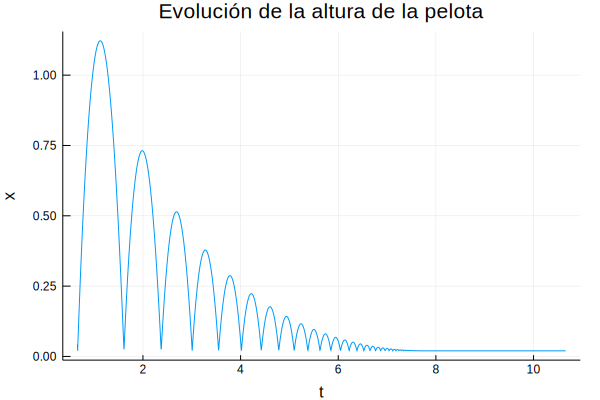

In [34]:
t0 = res[selIx,1]
u0 = res[selIx,2:3]

p = [9.8,0.0028,0.02,1.789*10.0^(-5),1.205,0.9]

uj = zeros(2401,2)
tj = zeros(2401,1)

uj[1,:] = u0
tj[1] = t0

for ix in 2:2401
    uj[ix,:] = RK4step(tj[ix-1],uj[ix-1,:],1/240,fpelota,gSuelo,rbote,p)
    tj[ix] = tj[ix-1]+1/240
end

tt = tj
xx = uj[:,1]
vv = uj[:,2]

plot(tt,xx,title="Evolución de la altura de la pelota",xlabel="t", ylabel="x",label="")

In [35]:
data="./data.txt"
f1=open(data,"w");
writedlm(f1,xx)
close(f1);

>**Comentar los resultados**
>
> La grafica y la animacion muestran que la pelota de ping pong da botes que van disminuando en su amplitud con cada bote hasta que la pelota no se mueve y queda en el suelo.
>
> Tambien podemos observar que la cordenada x de la pelota nunca esta debajo de zero.
>
> Por lo cual, podemos asumir que la simulacion del movimiento de la pelota esta correcto y preciso.

<a href="#top">Back to the top</a>

## 7 Valoración

_Incluir aquí los comentarios de valoración de la tarea a entregar (dificultad, interés, etc, incluidas, si se quiere, sugerencias de mejora del ejercicio), así como una estimación del tiempo dedicado al trabajo de la semana (desglosado en el tiempo de estudio de material teórico, tiempo de dedicación a la participación activa o pasiva en los foros, tiempo de implementación y experimentación con los problemas prácticos planteados, y tiempo de preparación del documento jupyter final)._

> **dificultad:** muy atla !!!
>
> **interés:** alto!!! he apprendido mucho !!!
>
> **sugerencias de mejora del ejercicio**: los errores en el enunciado me han cuestado mucho tiempo. 
>
> **tiempo dedicado:**
> + tiempo de estudio material teorico: 2h
> + tiempo de dedicacion en el foro: 2 h
> + tiempo de implementacion y experimentacion: 14h
> + tiempo de preparacion del documento jupyter: 2h